<a href="https://colab.research.google.com/github/UmutMD/pokemon-type-classification/blob/main/poke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

import os
from pathlib import Path
import re

import tensorflow as tf



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_dir = '/content/drive/MyDrive/Projects/Pokemon-Classification/images/images'

In [4]:
train_path = Path(train_dir)

In [5]:
files = list (train_path.glob('*.png'))
files
names = [os.path.split(x)[1] for x in list(train_path.glob('*.png'))]

image_df= pd.concat ([pd.Series(names, name = 'Name'), pd.Series(files, name ='Filepath').astype(str) ], axis= 1)

image_df['Name'] = image_df ['Name'].apply( lambda x: re.sub (r'\.\w+$','',x))


In [6]:
df = pd.read_csv ('/content/drive/MyDrive/Projects/Pokemon-Classification/pokemon.csv')
df



,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


Image augmentation



In [7]:
image_df

,Name,Filepath
0,accelgor,/content/drive/MyDrive/Projects/Pokemon-Classi...
1,abra,/content/drive/MyDrive/Projects/Pokemon-Classi...
2,aegislash-blade,/content/drive/MyDrive/Projects/Pokemon-Classi...
3,abomasnow,/content/drive/MyDrive/Projects/Pokemon-Classi...
4,absol,/content/drive/MyDrive/Projects/Pokemon-Classi...
...,...,...
716,whismur,/content/drive/MyDrive/Projects/Pokemon-Classi...
717,yanmega,/content/drive/MyDrive/Projects/Pokemon-Classi...
718,wynaut,/content/drive/MyDrive/Projects/Pokemon-Classi...
719,wingull,/content/drive/MyDrive/Projects/Pokemon-Classi...


In [8]:
train_df = image_df.merge(df, on= 'Name')
train_df

train_df = train_df.drop('Type2', axis=1)


In [9]:
train_df

,Name,Filepath,Type1
0,accelgor,/content/drive/MyDrive/Projects/Pokemon-Classi...,Bug
1,abra,/content/drive/MyDrive/Projects/Pokemon-Classi...,Psychic
2,aegislash-blade,/content/drive/MyDrive/Projects/Pokemon-Classi...,Steel
3,abomasnow,/content/drive/MyDrive/Projects/Pokemon-Classi...,Grass
4,absol,/content/drive/MyDrive/Projects/Pokemon-Classi...,Dark
...,...,...,...
716,whismur,/content/drive/MyDrive/Projects/Pokemon-Classi...,Normal
717,yanmega,/content/drive/MyDrive/Projects/Pokemon-Classi...,Bug
718,wynaut,/content/drive/MyDrive/Projects/Pokemon-Classi...,Psychic
719,wingull,/content/drive/MyDrive/Projects/Pokemon-Classi...,Water


In [10]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split =0.2,
    rescale = 1./255

)

In [11]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col= 'Filepath',
    y_col= 'Type1',
    target_size= (120,120),
    color_node = 'rgba',
    class_node ='sparse',
    batch_size = 32,
    shuffle= True,
    seed= 1,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col= 'Filepath',
    y_col= 'Type1',
    target_size= (120,120),
    color_node = 'rgba',
    class_node ='sparse',
    batch_size = 32,
    shuffle= True,
    seed= 1,
    subset = 'validation'


)

Found 577 validated image filenames belonging to 18 classes.
Found 144 validated image filenames belonging to 18 classes.


Finally solved 2 day error.......................


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


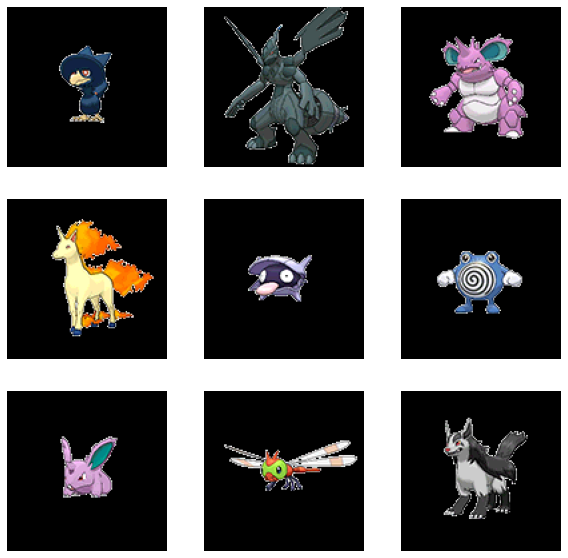

In [12]:
image_sample= train_data.next()[0]

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image_sample[i,:,:,:])
  plt.axis('off')
plt.show()

# Feature extraction and model building


In [13]:

inputs = tf.keras.Input(shape=(120,120,3))

conv1= tf.keras.layers.Conv2D (filters =64, kernel_size=(8,8), activation='relu')(inputs)
pool1 = tf.keras.layers.MaxPool2D()(conv1)

conv2= tf.keras.layers.Conv2D (filters =128, kernel_size=(8,8), activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPool2D()(conv2)

conv3= tf.keras.layers.Conv2D (filters =256, kernel_size=(8,8), activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPool2D()(conv3)

outputs =tf.keras.layers.GlobalAveragePooling2D()(pool3)



feature_extractor = tf.keras.Model(inputs=inputs, outputs= outputs)
feature_extractor.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 64)      12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 256)       209740

120 to 120 then we conv to 113 to 56

#Classification


In [14]:
clf_inputs = feature_extractor.input
clf_outputs = tf.keras.layers.Dense(units= 1, activation= 'sigmoid')(feature_extractor.output)

classifier = tf.keras.Model(inputs= clf_inputs, outputs= clf_outputs)


In [15]:
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 64)      12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 256)       2097

Model with classfiers at the end dense(Dense)

In [16]:
classifier.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)


In [17]:
history = classifier.fit(
    train_data,
    validation_data = val_data,
    batch_size = 32,
    epochs= 7,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(
                     monitor= 'val_loss',
                     patience = 5,
                     restore_best_weights = True
                 ),
                 tf.keras.callbacks.ReduceLROnPlateau()
    ]
)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/7
19/19 [==============================] - 186s 10s/step - loss: 0.2953 - accuracy: 0.8951 - val_loss: 0.2348 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 2/7
19/19 [==============================] - 167s 9s/step - loss: 0.2229 - accuracy: 0.9444 - val_loss: 0.2180 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 3/7
19/19 [==============================] - 165s 9s/step - loss: 0.2167 - accuracy: 0.9444 - val_loss: 0.2167 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 4/7
19/19 [==============================] - 164s 9s/step - loss: 0.2156 - accuracy: 0.9444 - val_loss: 0.2154 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 5/7
19/19 [==============================] - 165s 9s/step - loss: 0.2151 - accuracy: 0.9444 - val_loss: 0.2152 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 6/7
19/19 [==============================] - 167s 9s/step - loss: 0.2151 - accuracy: 0.9444 - val_loss: 0.2150 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 7/7
19/19 [==============================] - 166s 9s/step - loss: 0.2150 - 

It's not going better on accuracy  

epoch 23/ loss: 0.2148  accuracy 0.944 


Accuracy did not improve , and did not save the weights, gonna do 10 epoch and move on


In [19]:
feature_extractor.layers

#feature_extractor.layers.weights.shape

In [24]:
feature_extractor.layers[1].weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(8, 8, 64, 128) dtype=float32, numpy=
 array([[[[-1.97986662e-02,  1.88898258e-02,  1.90267731e-02, ...,
           -2.96449114e-04,  1.62617285e-02,  1.04859248e-02],
          [ 1.60911065e-02,  3.55676794e-03,  1.03351241e-02, ...,
            6.41957298e-03,  1.52884154e-02,  1.96411200e-02],
          [ 2.95082238e-02,  1.22756464e-02,  1.45434802e-02, ...,
           -1.16416253e-02,  3.46917547e-02, -1.52635006e-02],
          ...,
          [-1.35400649e-02,  2.03800015e-02,  2.61041969e-02, ...,
           -1.68927712e-03,  2.90373135e-02, -1.55831076e-04],
          [-8.09971243e-03,  5.80411777e-03,  2.41921283e-02, ...,
            7.63811031e-03,  3.07551380e-02, -1.75076793e-03],
          [ 2.03261781e-03,  2.50173565e-02, -1.63373742e-02, ...,
           -2.07880363e-02, -3.59881367e-03, -1.51664140e-02]],
 
         [[ 1.25956833e-02, -5.44917537e-03, -1.51778860e-02, ...,
           -2.07716487e-02,  1.81314852e-02,  1.58242509e

In [25]:
feature_extractor.layers[3].weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(8, 8, 64, 128) dtype=float32, numpy=
 array([[[[-1.97986662e-02,  1.88898258e-02,  1.90267731e-02, ...,
           -2.96449114e-04,  1.62617285e-02,  1.04859248e-02],
          [ 1.60911065e-02,  3.55676794e-03,  1.03351241e-02, ...,
            6.41957298e-03,  1.52884154e-02,  1.96411200e-02],
          [ 2.95082238e-02,  1.22756464e-02,  1.45434802e-02, ...,
           -1.16416253e-02,  3.46917547e-02, -1.52635006e-02],
          ...,
          [-1.35400649e-02,  2.03800015e-02,  2.61041969e-02, ...,
           -1.68927712e-03,  2.90373135e-02, -1.55831076e-04],
          [-8.09971243e-03,  5.80411777e-03,  2.41921283e-02, ...,
            7.63811031e-03,  3.07551380e-02, -1.75076793e-03],
          [ 2.03261781e-03,  2.50173565e-02, -1.63373742e-02, ...,
           -2.07880363e-02, -3.59881367e-03, -1.51664140e-02]],
 
         [[ 1.25956833e-02, -5.44917537e-03, -1.51778860e-02, ...,
           -2.07716487e-02,  1.81314852e-02,  1.58242509e

In [28]:
feature_extractor.layers[5].weights[0].shape

TensorShape([8, 8, 128, 256])

Weights of the convolutional layers

# Visual

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

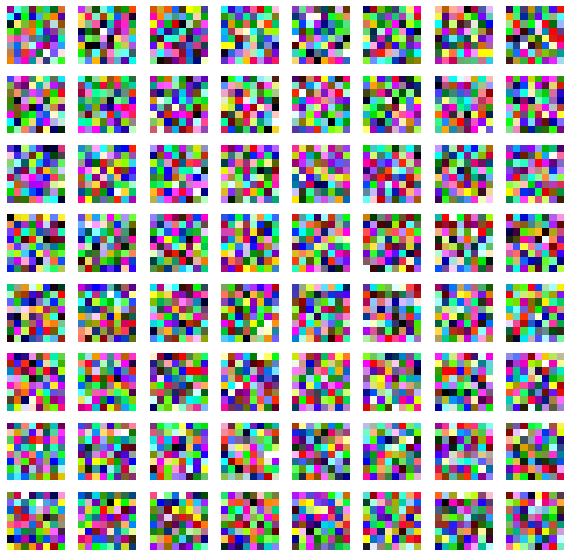

In [36]:
plt.figure(figsize=(10,10))
for i in range(64):
      plt.subplot(8,8, i+1)
      img = feature_extractor.layers[1].weights[0][:, :, :, i].numpy().copy()
      for channel in range(3):
        img[:, :, channel] = minmax_scale(img[:,:, channel])
      plt.imshow(img)
      plt.axis('off')
plt.show()

Weights visualized in the first conv. layer